#### From the previous model built, 
We see that the model's prediction on realworld data is pretty nonsensical. This might be because of model not being able to learn all the features -- or it may have been overfit. Let's try some regularization techniques.

In [1]:
# import required libraries
import numpy as np
import os, sys
import torch
# datasets
import torchvision.datasets as datasets
# transforms
import torchvision.transforms as transforms
# for plots
import matplotlib.pyplot as plt
# neural network modules
import torch.nn as nn
# PyTorch utilities
from torch.utils.data import DataLoader
# optimizers
import torch.optim as optim

import importlib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import utilities
from src.utilities import train_model, evaluate, plot_metrics, prediction_and_image, print_conclusion, realworld_prediction
importlib.reload(utilities)

<module 'src.utilities' from '/home/ravi/Desktop/deep-learning-projects/mnist-cnn/src/utilities.py'>

In [2]:
# set device to cuda(gpu)
device = torch.device("cuda")

In [3]:
# define transform
transform = transforms.Compose(
    [
        transforms.ToTensor() # transform from the image datatype to PyTorch Tensors
    ]
)
# load the dataset
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform)

### Build a CNN Model with regularization

In [88]:
class CNNReg(nn.Module):
    def __init__(self):
        super(CNNReg, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=24,out_channels=48,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()

        # Add regularization (here, dropout)
        self.dropout = nn.Dropout()

        self.fc_linear_1 = nn.Linear(in_features=48*5*5, out_features=512)
        self.relu = nn.ReLU()

        self.fc_linear_2 = nn.Linear(in_features=512, out_features=256)
        self.fc_linear_3 = nn.Linear(in_features=256, out_features=128)
        self.fc_linear_4 = nn.Linear(in_features=128, out_features=64)
        self.fc_linear_5 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self,X):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool1(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool2(X)

        X = self.flatten(X)

        X = self.dropout(X)
        
        X = self.fc_linear_1(X)
        X = self.relu(X)
        X = self.fc_linear_2(X)
        X = self.relu(X)
        X = self.fc_linear_3(X)
        X = self.relu(X)
        X = self.fc_linear_4(X)
        X = self.relu(X)
        X = self.fc_linear_5(X)
        return X

### Now train the model

EPOCH: 1...
EPOCH: 2...
EPOCH: 3...
EPOCH: 4...
EPOCH: 5...
EPOCH: 6...
EPOCH: 7...
EPOCH: 8...
EPOCH: 9...
EPOCH: 10...
EPOCH: 11...
EPOCH: 12...
EPOCH: 13...
EPOCH: 14...
EPOCH: 15...
EPOCH: 16...
EPOCH: 17...
EPOCH: 18...
EPOCH: 19...
EPOCH: 20...


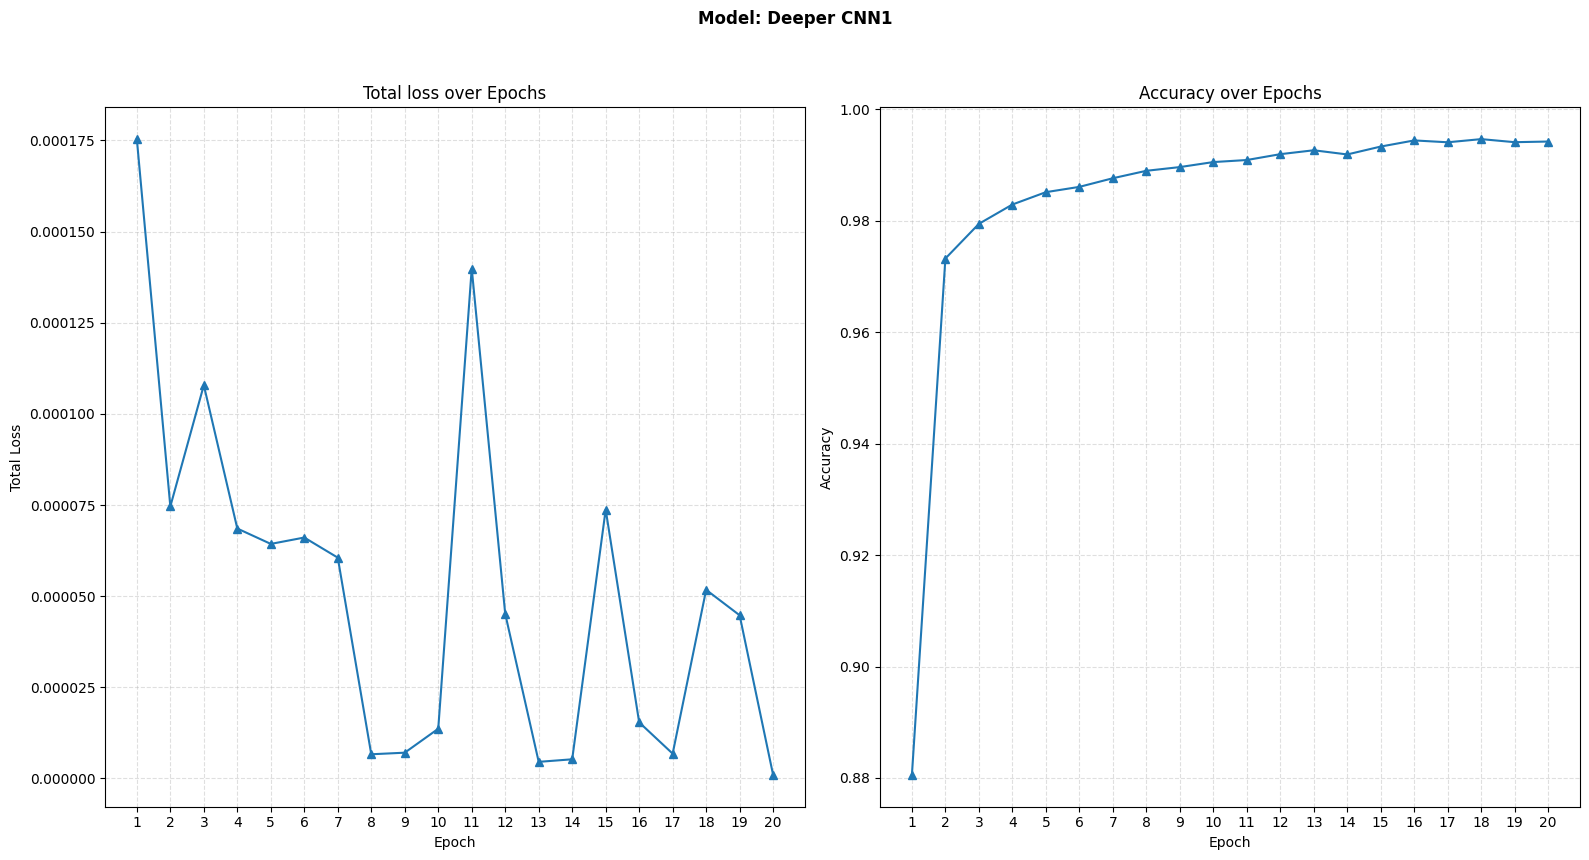

Model: Deeper CNN1
Loss(Training): 0.000001
Accuracy(Training): 0.994183
Loss(Testing): 0.022780
Accuracy(Testing): 0.992700


In [89]:
# instantiate the model and move to device
cnn_reg_1 = CNNReg().to(device)

# define batch size, dataloader, optimizer, and loss functions

# batch size
BATCHSIZE1 = 128
# dataloader
trainset_loader1 = DataLoader(train_dataset, BATCHSIZE1, shuffle=True)
testset_loader1 = DataLoader(test_dataset, BATCHSIZE1, shuffle=False)

# loss function (Cost Function)
loss_function = torch.nn.CrossEntropyLoss()

# optimizer - starting with the simplest one and with default learning rate
optimizer1 = optim.Adam(cnn_reg_1.parameters())

EPOCHS = 20

# train the model
losses1, accuracies1 = train_model(cnn_reg_1, trainset_loader1, loss_function, optimizer1, EPOCHS)

plot_metrics(losses1, accuracies1, "Deeper CNN1")

# Evaluate the model with test set
test_loss, test_accuracy = evaluate(cnn_reg_1, testset_loader1, loss_function)

print_conclusion("Deeper CNN1", losses1, accuracies1, test_loss, test_accuracy)

In [110]:
from PIL import Image, ImageOps
# Load the original image using Pillow
org_image = Image.open("../ravi-handwritten-digits/0.jpg")

# Define a transform pipeline to convert to grayscale
# num_output_channels=1 ensures it's a single-channel image
transform_to_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Lambda(lambda img: ImageOps.invert(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Apply the transformation
grayscale_tensor = transform_to_gray(org_image)
thresh = 0.3  # Equivalent to 128 in an 8-bit image (128/255 ≈ 0.5)
low_value = 0.0
high_value = 1.0
thresholded_tensor = torch.where(grayscale_tensor >= thresh, high_value, low_value)

# The output is a tensor, ready for your model
print(f"Shape of the grayscale tensor: {grayscale_tensor.shape}") # Should be [1, 28, 28]

# to_pil = transforms.ToPILImage()
# thresholded_image = to_pil(grayscale_tensor)
# thresholded_image.show()

Shape of the grayscale tensor: torch.Size([1, 28, 28])


The image is of the digit (as recognized by our model): 9


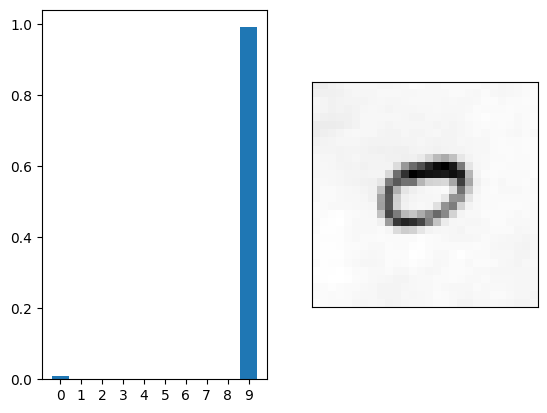

In [111]:
realworld_prediction(cnn_reg_1, grayscale_tensor)